#DA1 
EHR record analysis using GRU \
GUNA SHANKAR S \
20MIA1162

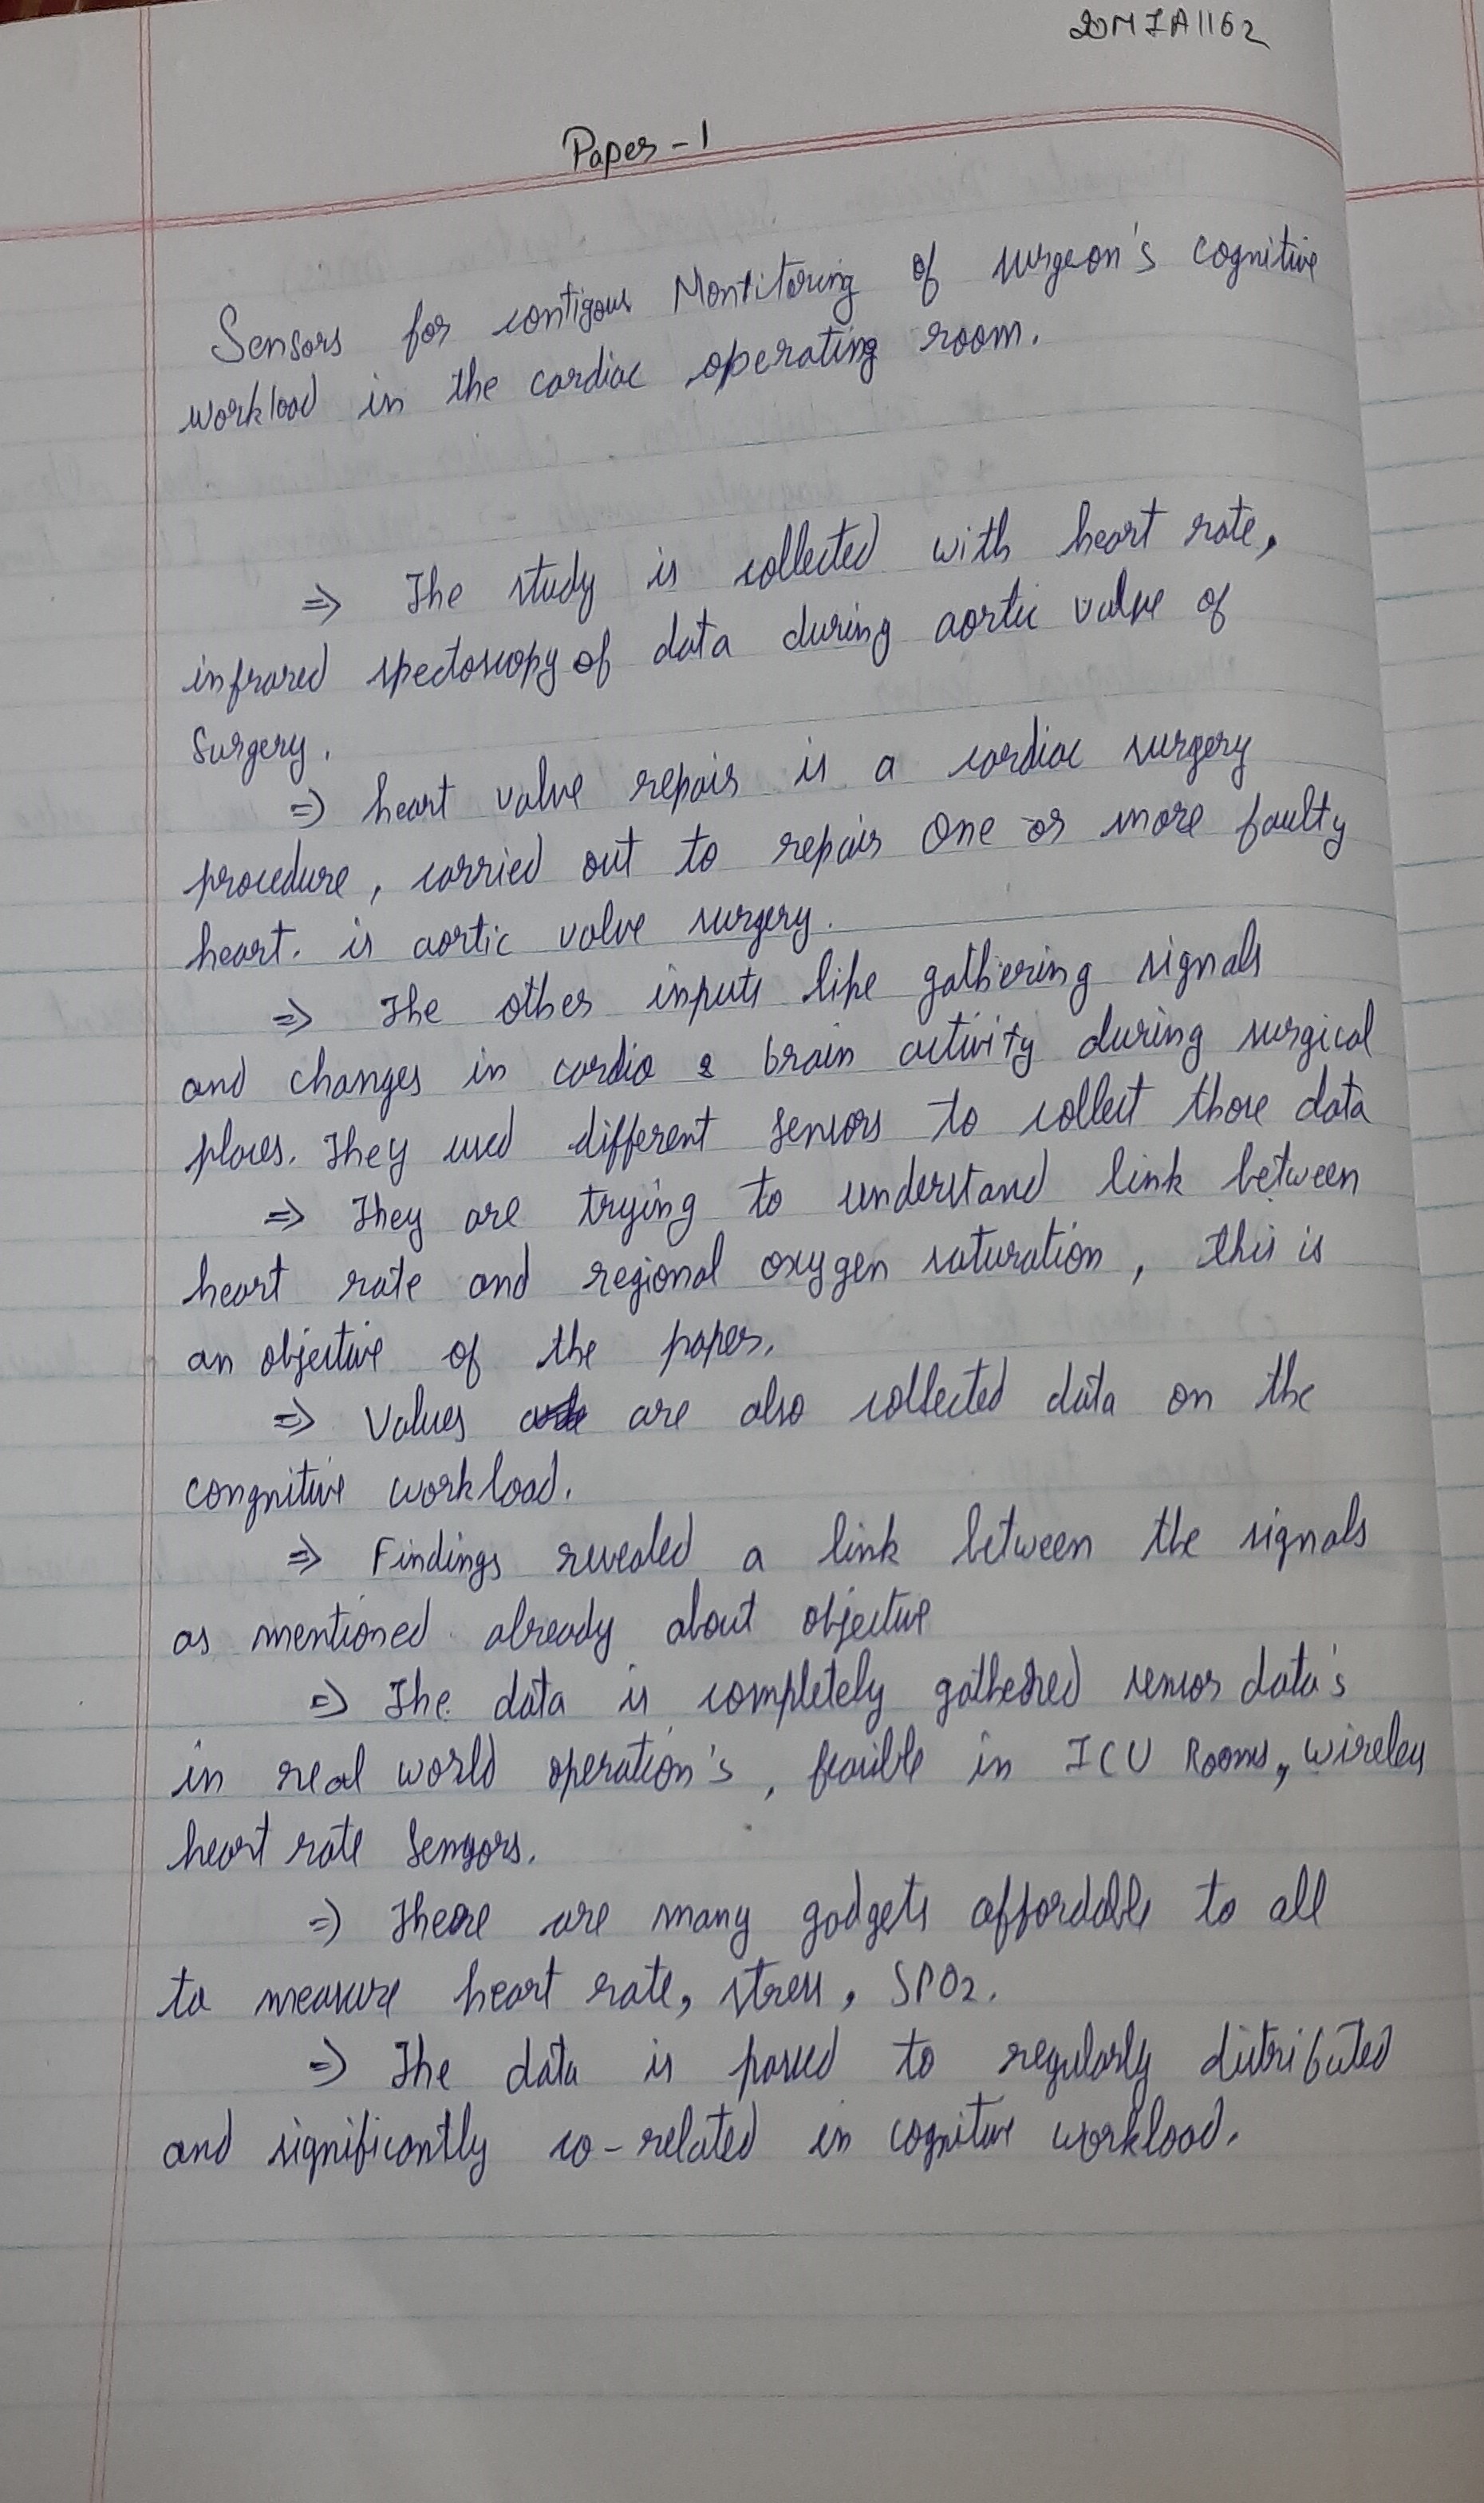

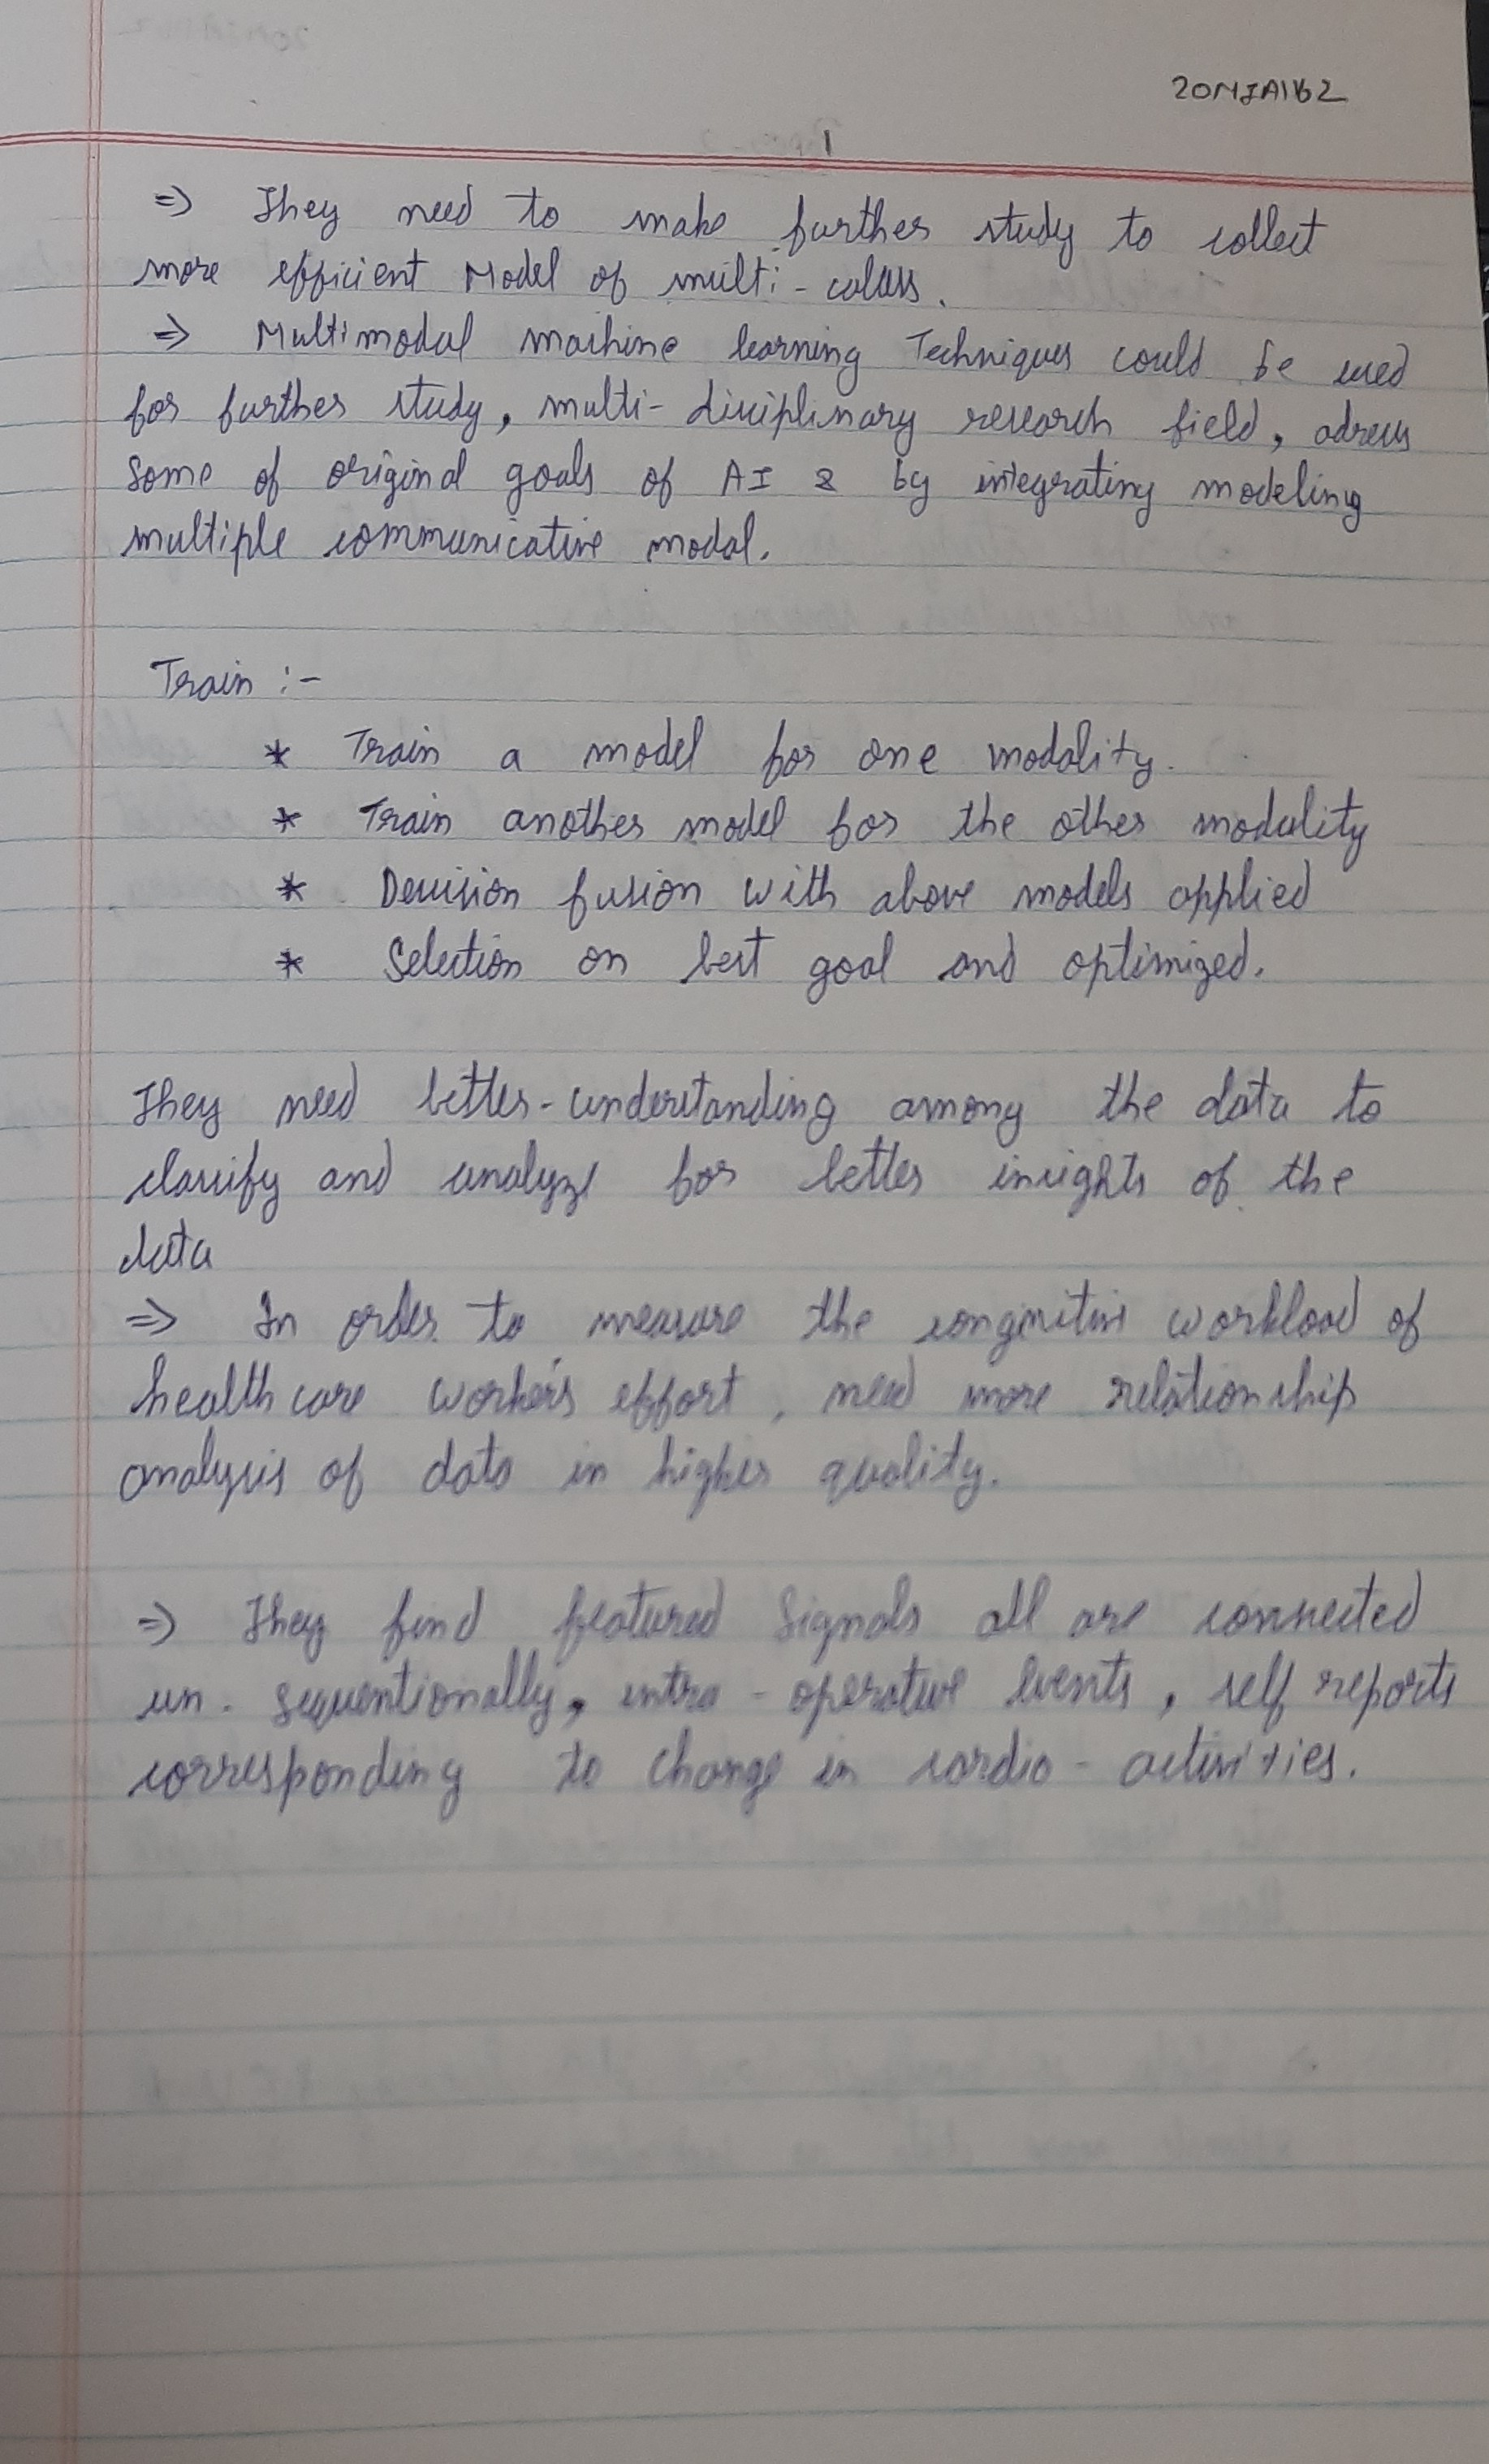

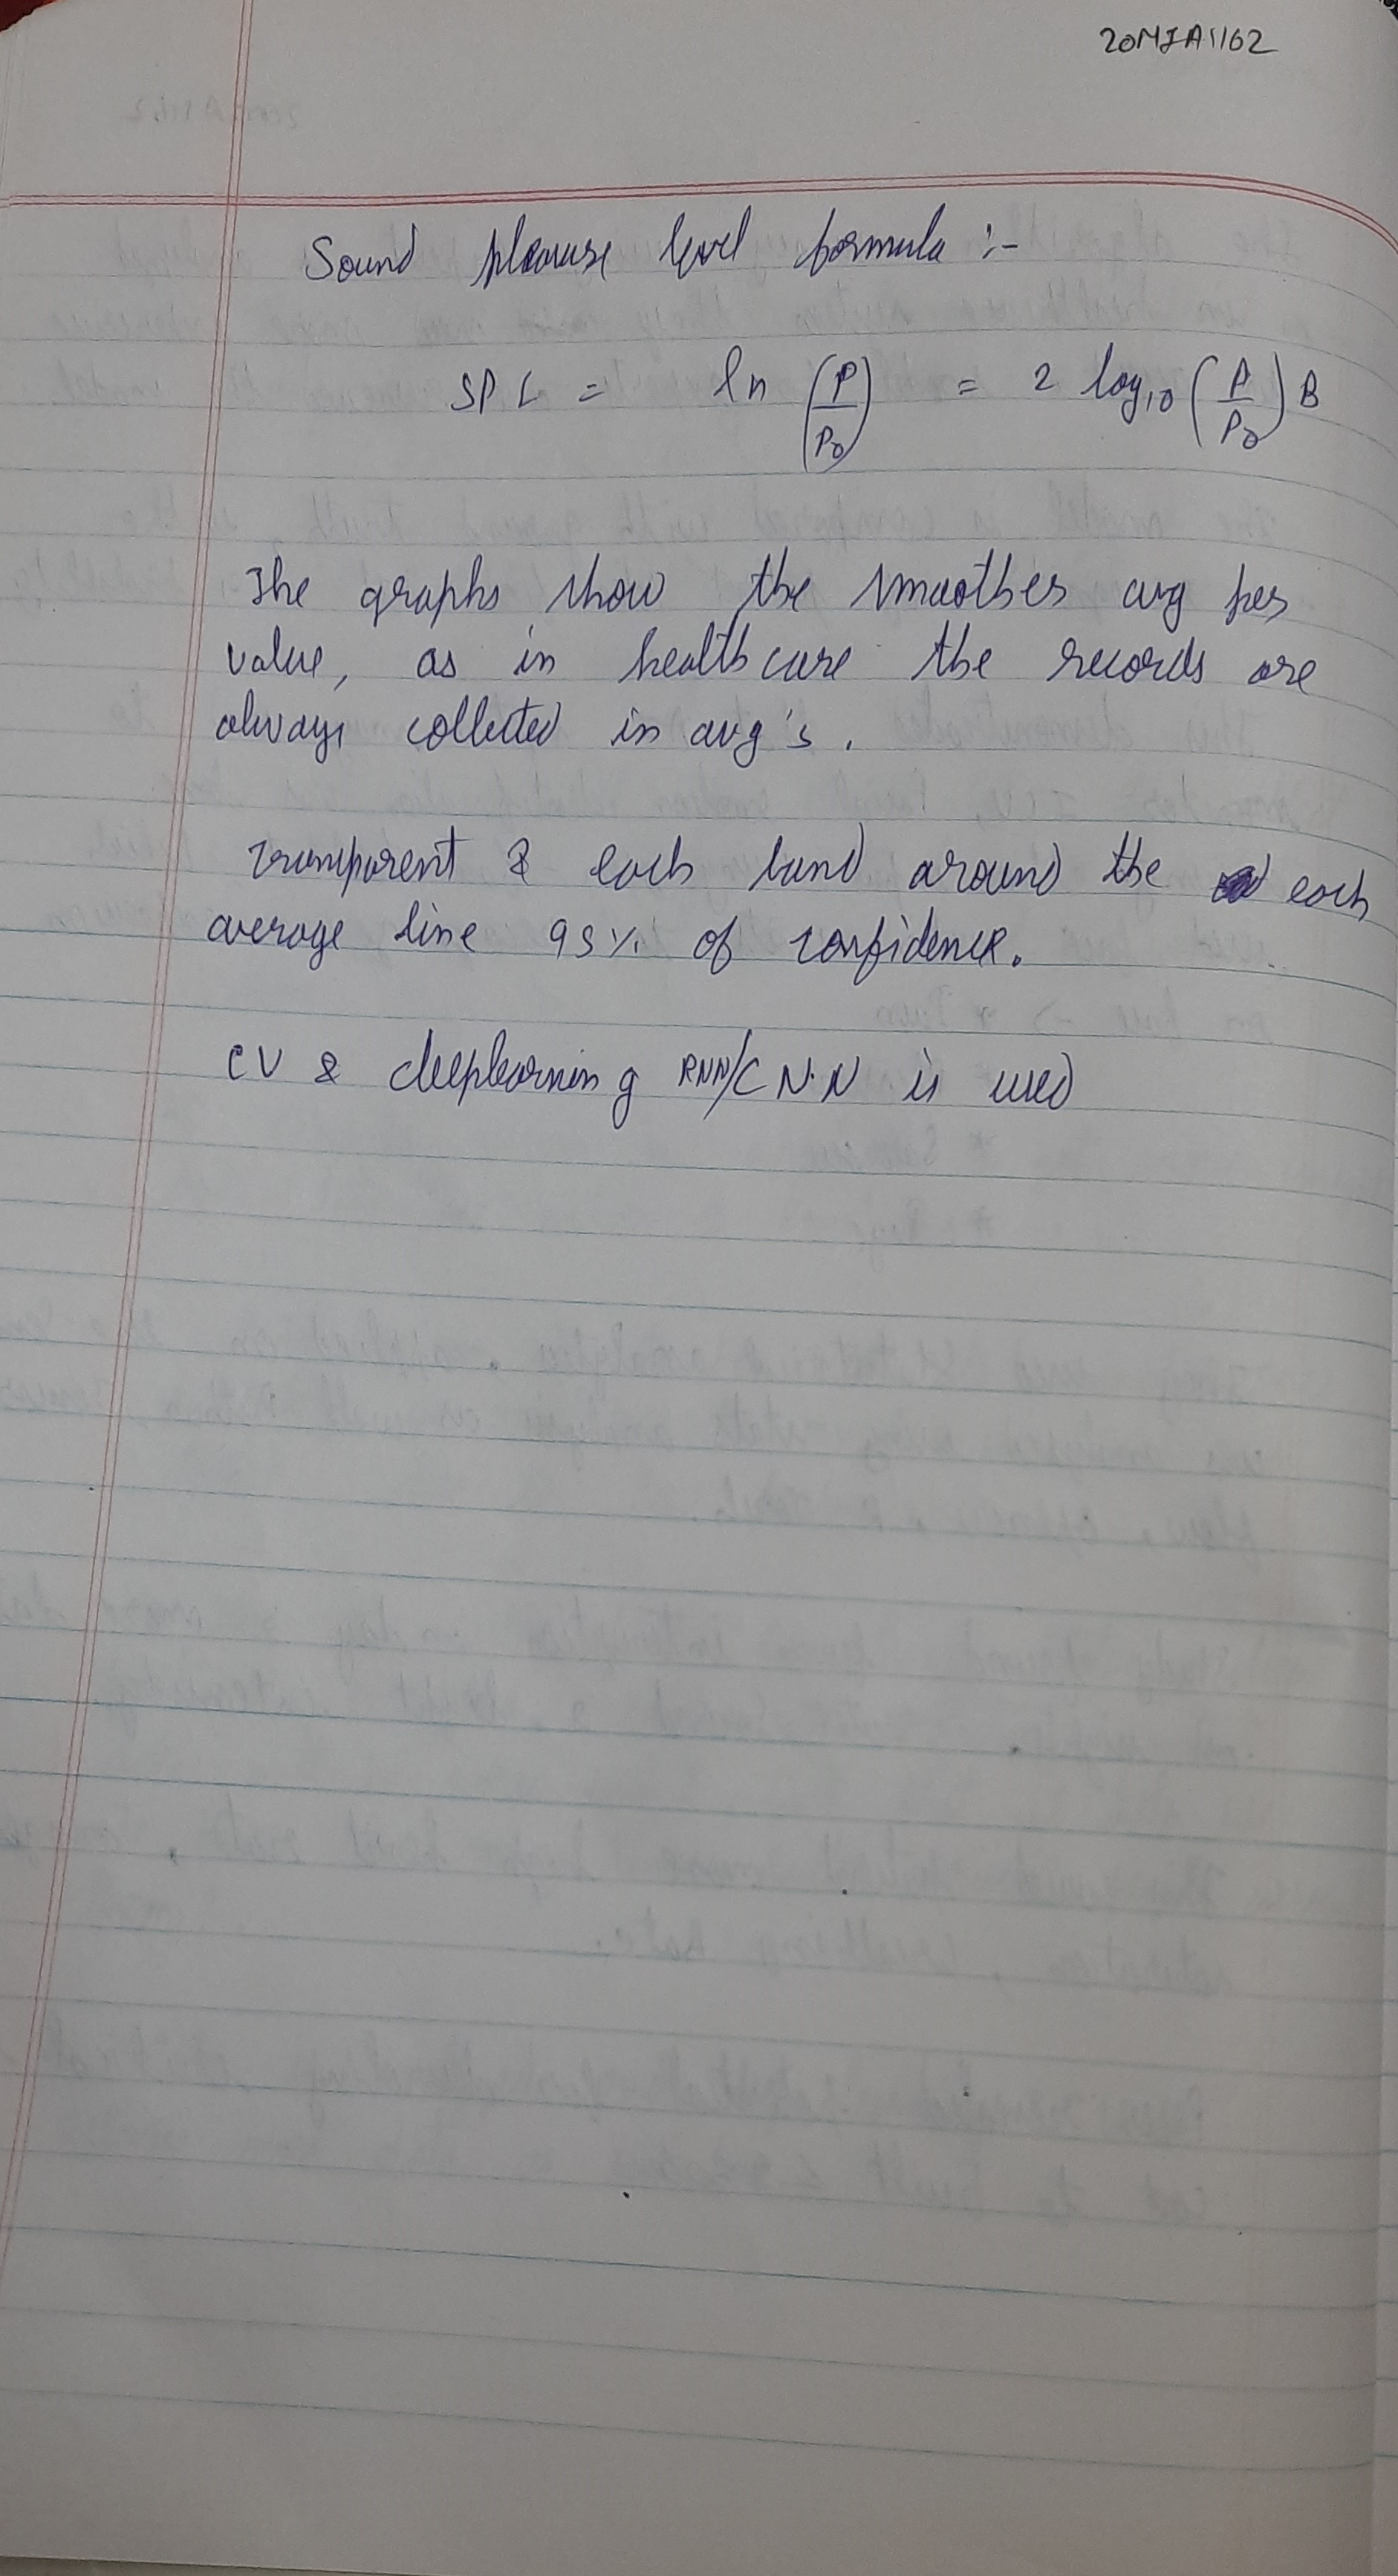

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
admission_table = pd.read_csv('/content/ADMISSIONS.csv')
admission_table.head(10)

row_id  subject_id  hadm_id            admittime            dischtime  \
0   12258       10006   142345  2164-10-23 21:09:00  2164-11-01 17:15:00   
1   12263       10011   105331  2126-08-14 22:32:00  2126-08-28 18:59:00   
2   12265       10013   165520  2125-10-04 23:36:00  2125-10-07 15:13:00   
3   12269       10017   199207  2149-05-26 17:19:00  2149-06-03 18:42:00   
4   12270       10019   177759  2163-05-14 20:43:00  2163-05-15 12:00:00   
5   12277       10026   103770  2195-05-17 07:39:00  2195-05-24 11:45:00   
6   12278       10027   199395  2190-07-13 07:15:00  2190-07-25 14:00:00   
7   12280       10029   132349  2139-09-22 10:58:00  2139-10-02 14:29:00   
8   12282       10032   140372  2138-04-02 19:52:00  2138-04-15 14:35:00   
9   12283       10033   157235  2132-12-05 02:46:00  2132-12-08 15:15:00   

             deathtime admission_type         admission_location  \
0                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1  2126-08-28 18:59:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
2  2125-10-07 15:13:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
4  2163-05-15 12:00:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
5                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
6                  NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
7                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
8                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
9                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   

         discharge_location insurance language           religion  \
0          HOME HEALTH CARE  Medicare      NaN           CATHOLIC   
1              DEAD/EXPIRED   Private      NaN           CATHOLIC   
2              DEAD/EXPIRED  Medicare      NaN           CATHOLIC   
3                       SNF  Medicare      NaN           CATHOLIC   
4              DEAD/EXPIRED  Medicare      NaN           CATHOLIC   
5  REHAB/DISTINCT PART HOSP  Medicare      NaN              OTHER   
6                       SNF  Medicare      NaN           CATHOLIC   
7                       SNF  Medicare      NaN  PROTESTANT QUAKER   
8  REHAB/DISTINCT PART HOSP  Medicare      NaN           CATHOLIC   
9                       SNF  Medicare     POLI           CATHOLIC   

  marital_status               ethnicity            edregtime  \
0      SEPARATED  BLACK/AFRICAN AMERICAN  2164-10-23 16:43:00   
1         SINGLE   UNKNOWN/NOT SPECIFIED                  NaN   
2            NaN   UNKNOWN/NOT SPECIFIED                  NaN   
3       DIVORCED                   WHITE  2149-05-26 12:08:00   
4       DIVORCED                   WHITE                  NaN   
5            NaN                   WHITE  2195-05-17 01:49:00   
6        MARRIED                   WHITE                  NaN   
7       DIVORCED                   WHITE  2139-09-22 06:03:00   
8        WIDOWED                   WHITE  2138-04-02 14:56:00   
9        MARRIED                   WHITE  2132-12-04 20:11:00   

             edouttime                                          diagnosis  \
0  2164-10-23 23:00:00                                             SEPSIS   
1                  NaN                                        HEPATITIS B   
2                  NaN                                             SEPSIS   
3  2149-05-26 19:45:00                                   HUMERAL FRACTURE   
4                  NaN                                ALCOHOLIC HEPATITIS   
5  2195-05-17 08:29:00                                         STROKE/TIA   
6                  NaN   MITRAL REGURGITATION;CORONARY ARTERY DISEASE\...   
7  2139-09-22 11:50:00                                  SYNCOPE;TELEMETRY   
8  2138-04-02 20:40:00                            RIGHT HUMEROUS FRACTURE   
9  2132-12-05 04:05:00                RENAL FAILIURE-SYNCOPE-HYPERKALEMIA   

   hospital_expire_flag  has_chartevents_data  
0                     0                     1

##Dataset Description

The given data appears to be a subset of a hospital's patient record database. Each row represents a single patient's admission to the hospital and contains various pieces of information such as the admission and discharge time, the reason for admission (diagnosis), and the patient's demographic information (marital status, ethnicity, etc.). The columns in the dataset are:

row_id: a unique identifier for each row\
subject_id: a unique identifier for each patient\
hadm_id: a unique identifier for each admission to the hospital\
admittime: the date and time when the patient was admitted to the hospital\
dischtime: the date and time when the patient was discharged from the hospital\
deathtime: the date and time of the patient's death (if applicable)\
admission_type: the type of admission (e.g. emergency, urgent, elective)\
admission_location: where the patient was when they were admitted to the hospital (e.g. emergency room, transfer from another hospital)\
discharge_location: where the patient was discharged to (e.g. home, skilled nursing facility)\
insurance: the patient's insurance type (e.g. Medicare, private)\
language: the patient's preferred language\
religion: the patient's religion\
marital_status: the patient's marital status\
ethnicity: the patient's ethnicity\
edregtime: the date and time when the patient arrived at the emergency department (if applicable)\
edouttime: the date and time when the patient left the emergency department (if applicable)\
diagnosis: the reason for the patient's admission to the hospital\
hospital_expire_flag: a flag indicating whether the patient died during their hospital stay (0 = no, 1 = yes)\
has_chartevents_data: a flag indicating whether the patient's chart data is available (0 = no, 1 = yes)\

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
from datetime import datetime
import torch
import pickle
from collections import defaultdict
warnings.filterwarnings('ignore')
sns.set(style='white')
%autosave 180

print('Creating visit date mapping')
patHashMap = dict(defaultdict(list)) # this creates a dictionary with a list of values for each patient:[number of visists]
visitMap = dict(defaultdict()) # this creates a dictionary with a mapping of the patientID : visitdates

data = pd.read_csv('/content/ADMISSIONS.csv')

for i, row in data.iterrows():
  visitDateID = datetime.strptime(row['admittime'],'%Y-%m-%d %H:%M:%S')
  patHashMap.setdefault(str(row['subject_id']), []).append(str(row['hadm_id'])) # create a mapping for each visit for a specific PatientID
  visitMap.setdefault(str(row['hadm_id']), []).append(visitDateID) # create a mapping for each visit for a specific Admission Date

#Patient ID- visit mapping
patHashMap

#Patient Admission ID- visit date mapping
visitMap

Autosaving every 180 seconds
Creating visit date mapping


{'142345': [datetime.datetime(2164, 10, 23, 21, 9)],
 '105331': [datetime.datetime(2126, 8, 14, 22, 32)],
 '165520': [datetime.datetime(2125, 10, 4, 23, 36)],
 '199207': [datetime.datetime(2149, 5, 26, 17, 19)],
 '177759': [datetime.datetime(2163, 5, 14, 20, 43)],
 '103770': [datetime.datetime(2195, 5, 17, 7, 39)],
 '199395': [datetime.datetime(2190, 7, 13, 7, 15)],
 '132349': [datetime.datetime(2139, 9, 22, 10, 58)],
 '140372': [datetime.datetime(2138, 4, 2, 19, 52)],
 '157235': [datetime.datetime(2132, 12, 5, 2, 46)],
 '110244': [datetime.datetime(2129, 3, 3, 16, 6)],
 '189483': [datetime.datetime(2185, 3, 24, 16, 56)],
 '111115': [datetime.datetime(2144, 2, 9, 17, 53)],
 '157839': [datetime.datetime(2147, 2, 23, 11, 43)],
 '148562': [datetime.datetime(2147, 2, 6, 12, 38)],
 '168674': [datetime.datetime(2185, 4, 14, 0, 23)],
 '124073': [datetime.datetime(2152, 10, 2, 16, 24)],
 '126949': [datetime.datetime(2129, 11, 24, 0, 31)],
 '133110': [datetime.datetime(2194, 7, 26, 23, 43)],
 '

In the code, we are reading the df table data from a CSV file using Python's built-in open function. Then, we are looping through each line in the file and splitting it on commas to extract the relevant information. We are using the datetime module to convert the admission date into a datetime object for easy manipulation.

We are then creating two dictionaries. The first dictionary patHashMap maps each patient ID to a list of their admission IDs. The second dictionary visitMap maps each admission ID to a list of admission dates.

These dictionaries are useful for tracking a patient's visits to the hospital and for analyzing time-based patterns of hospitalization.

In [ ]:
data.head(10)

row_id  subject_id  hadm_id            admittime            dischtime  \
0   12258       10006   142345  2164-10-23 21:09:00  2164-11-01 17:15:00   
1   12263       10011   105331  2126-08-14 22:32:00  2126-08-28 18:59:00   
2   12265       10013   165520  2125-10-04 23:36:00  2125-10-07 15:13:00   
3   12269       10017   199207  2149-05-26 17:19:00  2149-06-03 18:42:00   
4   12270       10019   177759  2163-05-14 20:43:00  2163-05-15 12:00:00   
5   12277       10026   103770  2195-05-17 07:39:00  2195-05-24 11:45:00   
6   12278       10027   199395  2190-07-13 07:15:00  2190-07-25 14:00:00   
7   12280       10029   132349  2139-09-22 10:58:00  2139-10-02 14:29:00   
8   12282       10032   140372  2138-04-02 19:52:00  2138-04-15 14:35:00   
9   12283       10033   157235  2132-12-05 02:46:00  2132-12-08 15:15:00   

             deathtime admission_type         admission_location  \
0                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1  2126-08-28 18:59:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
2  2125-10-07 15:13:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
4  2163-05-15 12:00:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
5                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
6                  NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
7                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
8                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
9                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   

         discharge_location insurance language           religion  \
0          HOME HEALTH CARE  Medicare      NaN           CATHOLIC   
1              DEAD/EXPIRED   Private      NaN           CATHOLIC   
2              DEAD/EXPIRED  Medicare      NaN           CATHOLIC   
3                       SNF  Medicare      NaN           CATHOLIC   
4              DEAD/EXPIRED  Medicare      NaN           CATHOLIC   
5  REHAB/DISTINCT PART HOSP  Medicare      NaN              OTHER   
6                       SNF  Medicare      NaN           CATHOLIC   
7                       SNF  Medicare      NaN  PROTESTANT QUAKER   
8  REHAB/DISTINCT PART HOSP  Medicare      NaN           CATHOLIC   
9                       SNF  Medicare     POLI           CATHOLIC   

  marital_status               ethnicity            edregtime  \
0      SEPARATED  BLACK/AFRICAN AMERICAN  2164-10-23 16:43:00   
1         SINGLE   UNKNOWN/NOT SPECIFIED                  NaN   
2            NaN   UNKNOWN/NOT SPECIFIED                  NaN   
3       DIVORCED                   WHITE  2149-05-26 12:08:00   
4       DIVORCED                   WHITE                  NaN   
5            NaN                   WHITE  2195-05-17 01:49:00   
6        MARRIED                   WHITE                  NaN   
7       DIVORCED                   WHITE  2139-09-22 06:03:00   
8        WIDOWED                   WHITE  2138-04-02 14:56:00   
9        MARRIED                   WHITE  2132-12-04 20:11:00   

             edouttime                                          diagnosis  \
0  2164-10-23 23:00:00                                             SEPSIS   
1                  NaN                                        HEPATITIS B   
2                  NaN                                             SEPSIS   
3  2149-05-26 19:45:00                                   HUMERAL FRACTURE   
4                  NaN                                ALCOHOLIC HEPATITIS   
5  2195-05-17 08:29:00                                         STROKE/TIA   
6                  NaN   MITRAL REGURGITATION;CORONARY ARTERY DISEASE\...   
7  2139-09-22 11:50:00                                  SYNCOPE;TELEMETRY   
8  2138-04-02 20:40:00                            RIGHT HUMEROUS FRACTURE   
9  2132-12-05 04:05:00                RENAL FAILIURE-SYNCOPE-HYPERKALEMIA   

   hospital_expire_flag  has_chartevents_data  
0                     0                     1

In [ ]:
# Check the shape of the dataset
print(data.shape)

(129, 19)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   row_id                129 non-null    int64 
 1   subject_id            129 non-null    int64 
 2   hadm_id               129 non-null    int64 
 3   admittime             129 non-null    object
 4   dischtime             129 non-null    object
 5   deathtime             40 non-null     object
 6   admission_type        129 non-null    object
 7   admission_location    129 non-null    object
 8   discharge_location    129 non-null    object
 9   insurance             129 non-null    object
 10  language              81 non-null     object
 11  religion              128 non-null    object
 12  marital_status        113 non-null    object
 13  ethnicity             129 non-null    object
 14  edregtime             92 non-null     object
 15  edouttime             92 non-null     ob

In [ ]:
summary = data.describe(include='all')
print(summary)

              row_id    subject_id        hadm_id            admittime  \
count     129.000000    129.000000     129.000000                  129   
unique           NaN           NaN            NaN                  129   
top              NaN           NaN            NaN  2164-10-23 21:09:00   
freq             NaN           NaN            NaN                    1   
mean    28036.441860  28010.410853  152343.441860                  NaN   
std     14036.548988  16048.502883   27858.788248                  NaN   
min     12258.000000  10006.000000  100375.000000                  NaN   
25%     12339.000000  10088.000000  128293.000000                  NaN   
50%     39869.000000  40310.000000  157235.000000                  NaN   
75%     40463.000000  42135.000000  174739.000000                  NaN   
max     41092.000000  44228.000000  199395.000000                  NaN   

                  dischtime            deathtime admission_type  \
count                   129                 

This is a summary of a dataset that contains information about hospital admissions for 129 patients.

The dataset includes information such as admission and discharge times, admission type, location, insurance, language, religion, marital status, ethnicity, and diagnosis.

Some observations from the summary are:

The most common admission type is emergency.\
The most common discharge location is dead/expired.\
The most common insurance type is Medicare.\
The most common language is English.\
The most common religion is Catholic.\
The most common diagnosis is sepsis.\
Around 31% of the patients died during their hospitalization.\
Almost all patients have chart events data available.\
It's important to note that without more context or domain knowledge, it's difficult to draw deeper insights or make any conclusions from this summary alone.

In [ ]:
print(admission_table.isnull().sum())
# Drop rows with missing values
admission_table.dropna(inplace=True)

# Print summary statistics for missing values after dropping rows
print(admission_table.isnull().sum())

row_id                  0
subject_id              0
hadm_id                 0
admittime               0
dischtime               0
deathtime               0
admission_type          0
admission_location      0
discharge_location      0
insurance               0
language                0
religion                0
marital_status          0
ethnicity               0
edregtime               0
edouttime               0
diagnosis               0
hospital_expire_flag    0
has_chartevents_data    0
dtype: int64
row_id                  0
subject_id              0
hadm_id                 0
admittime               0
dischtime               0
deathtime               0
admission_type          0
admission_location      0
discharge_location      0
insurance               0
language                0
religion                0
marital_status          0
ethnicity               0
edregtime               0
edouttime               0
diagnosis               0
hospital_expire_flag    0
has_chartevents_data    0

#EDA

<Axes: xlabel='admission_type', ylabel='count'>

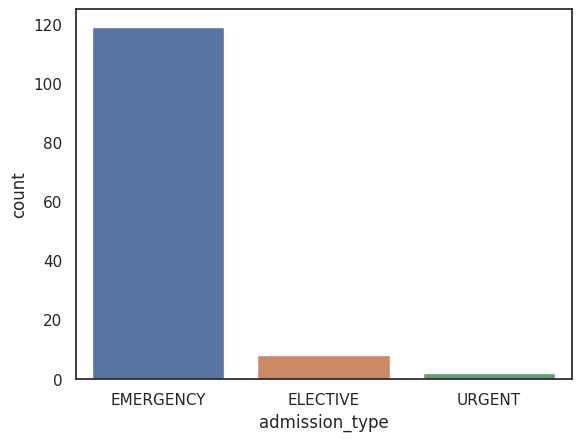

In [ ]:
df = pd.read_csv('/content/ADMISSIONS.csv')

admission_types = df['admission_type'].unique()
# Plot frequency of each admission type
sns.countplot(x='admission_type', data=df)

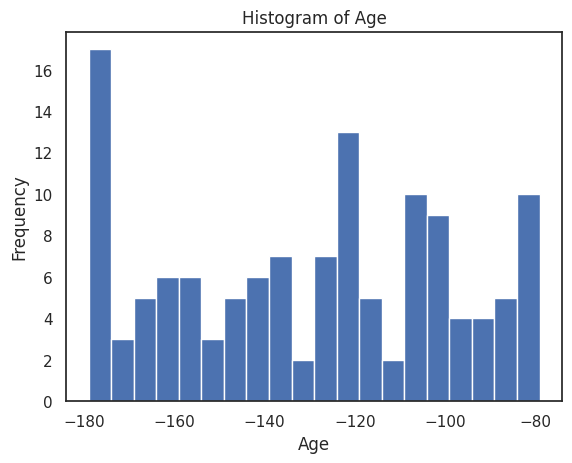

In [ ]:
import datetime as dt
import matplotlib.pyplot as plt

###### Here the date and time is wrong from given dataset since we got -ve values

# Convert admittime to datetime object
df['admittime'] = pd.to_datetime(df['admittime'])

# Calculate age in years based on admittime
df['age'] = ((dt.datetime.now() - df['admittime']) / pd.Timedelta(days=365.2425)).astype(int)

# Plot histogram of age
plt.hist(df['age'], bins=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age')
plt.show()

In [ ]:
df.head(5)

row_id  subject_id  hadm_id           admittime            dischtime  \
0   12258       10006   142345 2164-10-23 21:09:00  2164-11-01 17:15:00   
1   12263       10011   105331 2126-08-14 22:32:00  2126-08-28 18:59:00   
2   12265       10013   165520 2125-10-04 23:36:00  2125-10-07 15:13:00   
3   12269       10017   199207 2149-05-26 17:19:00  2149-06-03 18:42:00   
4   12270       10019   177759 2163-05-14 20:43:00  2163-05-15 12:00:00   

             deathtime admission_type         admission_location  \
0                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1  2126-08-28 18:59:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
2  2125-10-07 15:13:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
4  2163-05-15 12:00:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   

  discharge_location insurance language  religion marital_status  \
0   HOME HEALTH CARE  Medicare      NaN  CATHOLIC      SEPARATED   
1       DEAD/EXPIRED   Private      NaN  CATHOLIC         SINGLE   
2       DEAD/EXPIRED  Medicare      NaN  CATHOLIC            NaN   
3                SNF  Medicare      NaN  CATHOLIC       DIVORCED   
4       DEAD/EXPIRED  Medicare      NaN  CATHOLIC       DIVORCED   

                ethnicity            edregtime            edouttime  \
0  BLACK/AFRICAN AMERICAN  2164-10-23 16:43:00  2164-10-23 23:00:00   
1   UNKNOWN/NOT SPECIFIED                  NaN                  NaN   
2   UNKNOWN/NOT SPECIFIED                  NaN                  NaN   
3                   WHITE  2149-05-26 12:08:00  2149-05-26 19:45:00   
4                   WHITE                  NaN                  NaN   

             diagnosis  hospital_expire_flag  has_chartevents_data  age  
0               SEPSIS                     0                     1 -141  
1          HEPATITIS B                     1                     1 -103  
2               SEPSIS                     1                     1 -102  
3     HUMERAL FRACTURE                     0                     1 -126  
4  ALCOHOLIC HEPATITIS                     1                     1 -140

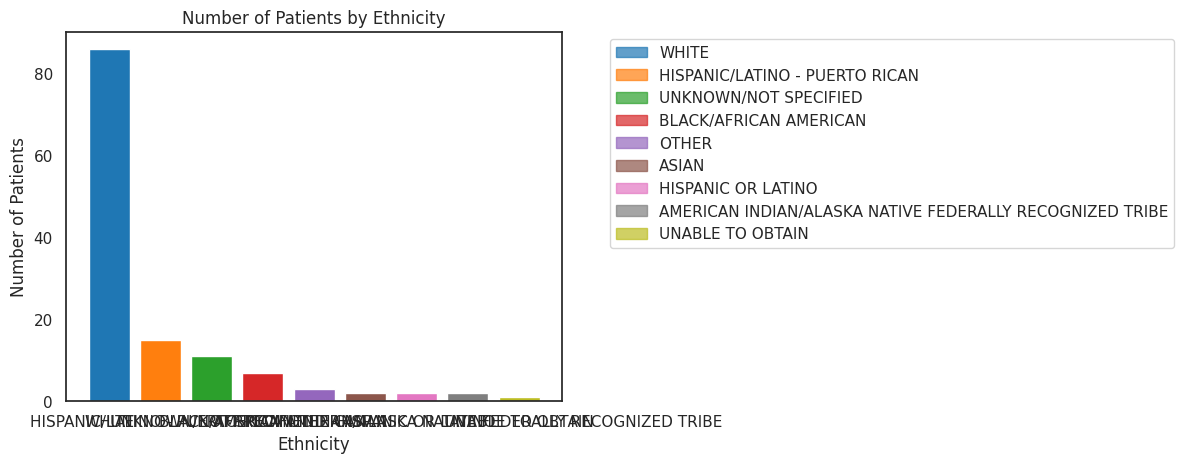

In [ ]:
ethnicity_counts = df['ethnicity'].value_counts()

# Define the colors for the bar chart
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Plot the bar chart
plt.bar(ethnicity_counts.index, ethnicity_counts.values, color=colors)

# Set the x-axis label, y-axis label, and title
plt.xlabel('Ethnicity')
plt.ylabel('Number of Patients')
plt.title('Number of Patients by Ethnicity')

# Create a legend for the bar chart
handles = []
for i, (ethnicity, count) in enumerate(ethnicity_counts.iteritems()):
    handles.append(plt.Rectangle((0,0), 1, 1, color=colors[i], alpha=0.7))
labels = ethnicity_counts.index.tolist()
plt.legend(handles, labels, loc='upper right', bbox_to_anchor=(2.25, 1))

# Display the plot
plt.show()

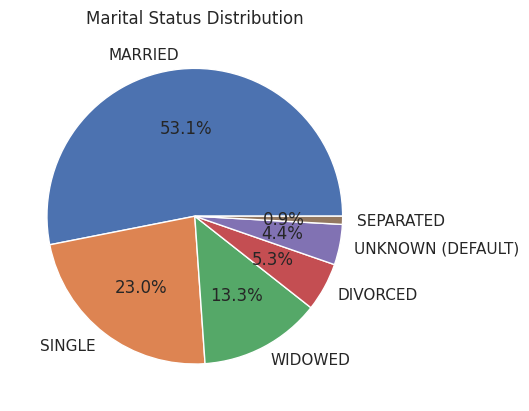

In [ ]:
marital_status_labels = {
    'S': 'Single',
    'M': 'Married',
    'W': 'Widowed',
    'D': 'Divorced',
    'U': 'Unknown'
}

# Replace the marital status codes with labels
df['marital_status'] = df['marital_status'].replace(marital_status_labels)

# Count the number of patients in each marital status group
marital_status_counts = df['marital_status'].value_counts()

# Plot a pie chart of the marital status distribution
plt.pie(marital_status_counts, labels=marital_status_counts.index, autopct='%1.1f%%')
plt.title('Marital Status Distribution')
plt.show()

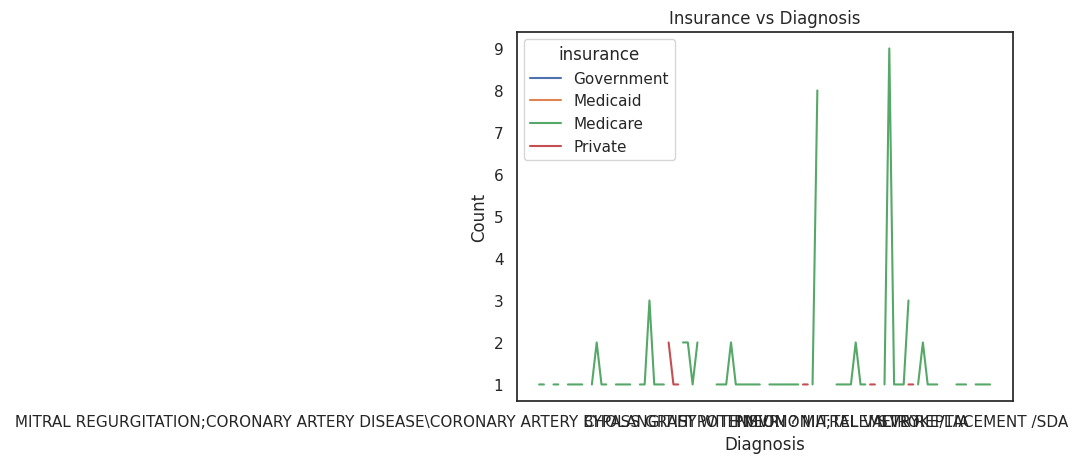

In [ ]:
# Group the data by insurance and diagnosis, and count the number of occurrences in each group
data = df.groupby(["insurance", "diagnosis"]).size().reset_index(name="count")

# Pivot the data to make insurance as the columns and diagnosis as the rows
data = data.pivot(index="diagnosis", columns="insurance", values="count")

# Plot the line chart
data.plot.line()

# Add labels and title
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.title("Insurance vs Diagnosis")
plt.show()

This will produce a line chart showing the count of each diagnosis for each insurance type. We can use this chart to compare the distribution of diagnoses among different insurance types.

##MODEL

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [ ]:
df = df.drop(['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'ethnicity', 'edregtime', 'edouttime', 'hospital_expire_flag', 'has_chartevents_data'], axis=1)


In [ ]:
label_encoder = LabelEncoder()
df['admission_type'] = label_encoder.fit_transform(df['admission_type'])
df['marital_status'] = label_encoder.fit_transform(df['marital_status'])
df['diagnosis'] = label_encoder.fit_transform(df['diagnosis'])


In [ ]:
df['age'] = df['age'].abs()
df.head(10)

admission_type  marital_status  diagnosis  age  year
0               1               2         73  141  2164
1               1               3         36  103  2126
2               1               6         73  102  2125
3               1               0         37  126  2149
4               1               0          8  140  2163
5               1               6         80  172  2195
6               0               1          0  167  2190
7               1               0         82  116  2139
8               1               5         67  114  2138
9               1               1         65  109  2132

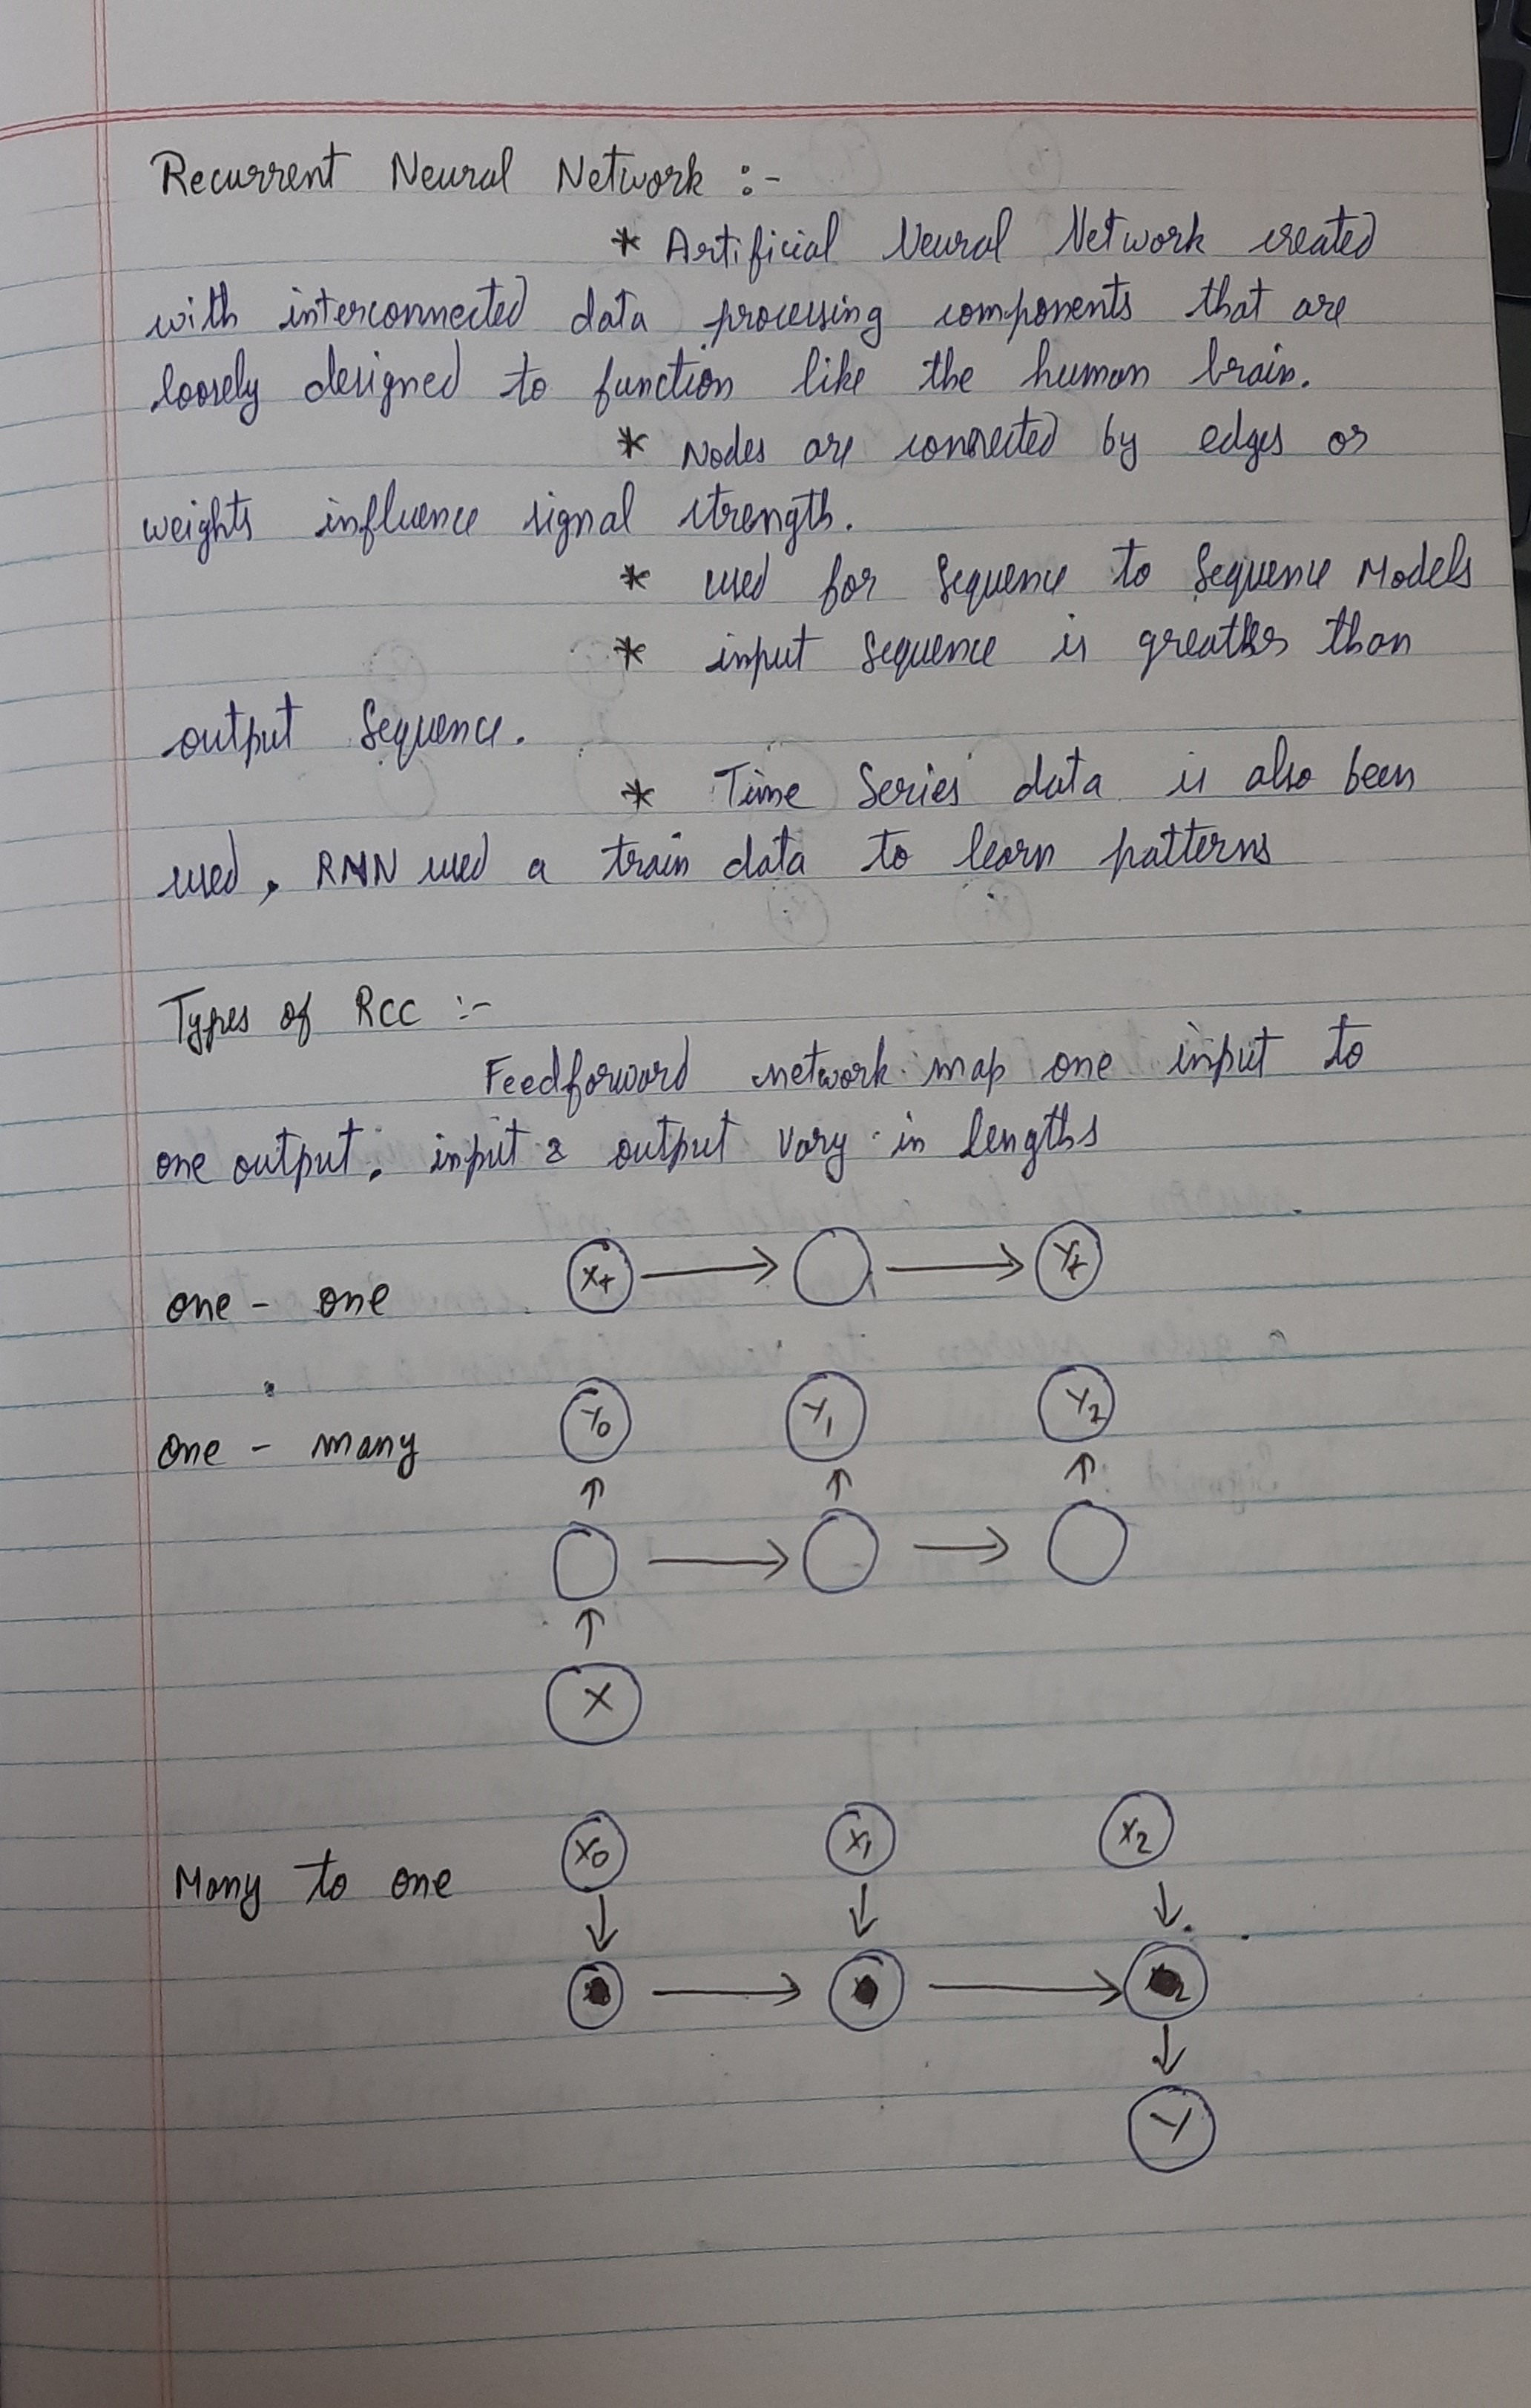

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['diagnosis'], df['diagnosis'], test_size=0.2, random_state=42)

tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train.astype(str))
X_train_sequences = tokenizer.texts_to_sequences(X_train.astype(str))
X_train_padded = pad_sequences(X_train_sequences, maxlen=100, truncating='post', padding='post')
X_test_sequences = tokenizer.texts_to_sequences(X_test.astype(str))
X_test_padded = pad_sequences(X_test_sequences, maxlen=100, truncating='post', padding='post')


# Build the model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64))
model.add(GRU(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, epochs=10, validation_data=(X_test_padded, y_test))

Epoch 1/10
4/4 [==============================] - 6s 427ms/step - loss: 1.3922 - accuracy: 0.0097 - val_loss: -2.3475 - val_accuracy: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 0s 120ms/step - loss: -3.8445 - accuracy: 0.0097 - val_loss: -8.4598 - val_accuracy: 0.0000e+00
Epoch 3/10
4/4 [==============================] - 0s 119ms/step - loss: -10.7677 - accuracy: 0.0097 - val_loss: -18.5105 - val_accuracy: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 0s 118ms/step - loss: -22.8792 - accuracy: 0.0097 - val_loss: -37.0611 - val_accuracy: 0.0000e+00
Epoch 5/10
4/4 [==============================] - 0s 117ms/step - loss: -44.3833 - accuracy: 0.0097 - val_loss: -67.4017 - val_accuracy: 0.0000e+00
Epoch 6/10
4/4 [==============================] - 0s 119ms/step - loss: -77.1619 - accuracy: 0.0097 - val_loss: -104.4363 - val_accuracy: 0.0000e+00
Epoch 7/10
4/4 [==============================] - 0s 124ms/step - loss: -113.5675 - accuracy: 0.0097 - val_loss: -13

In [ ]:
df.head()

admission_type    admission_location discharge_location insurance language  \
28      EMERGENCY  EMERGENCY ROOM ADMIT       DEAD/EXPIRED  Medicare     MAND   
52      EMERGENCY  EMERGENCY ROOM ADMIT       DEAD/EXPIRED  Medicare     RUSS   
72      EMERGENCY  EMERGENCY ROOM ADMIT       DEAD/EXPIRED  Medicare     ENGL   
92      EMERGENCY  EMERGENCY ROOM ADMIT       DEAD/EXPIRED  Medicare     ENGL   
96      EMERGENCY  EMERGENCY ROOM ADMIT       DEAD/EXPIRED  Medicaid     ENGL   

               religion marital_status  \
28        NOT SPECIFIED        MARRIED   
52               JEWISH        WIDOWED   
72        NOT SPECIFIED        WIDOWED   
92  ROMANIAN EAST. ORTH        MARRIED   
96               MUSLIM        MARRIED   

                                            ethnicity  hospital_expire_flag  \
28                                              ASIAN                     1   
52                                              WHITE                     1   
72                                              WHITE                     1   
92                                              WHITE                     1   
96  AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...                     1   

    has_chartevents_data  edregtime_day  edregtime_month  edregtime_hour  \
28                     1             21                3              17   
52                     1             16                4              11   
72                     1              7                3              18   
92                     1             26                7              15   
96                     1              6               10              19   

    edregtime_minute  edouttime_day  edouttime_month  edouttime_hour  \
28                24             22                3               1   
52                51             16                4              21   
72                24              8                3               3   
92                 1             26                7              18   
96                19              6               10              22   

    edouttime_minute  
28                12  
52                38  
72                45  
92                24  
96                26

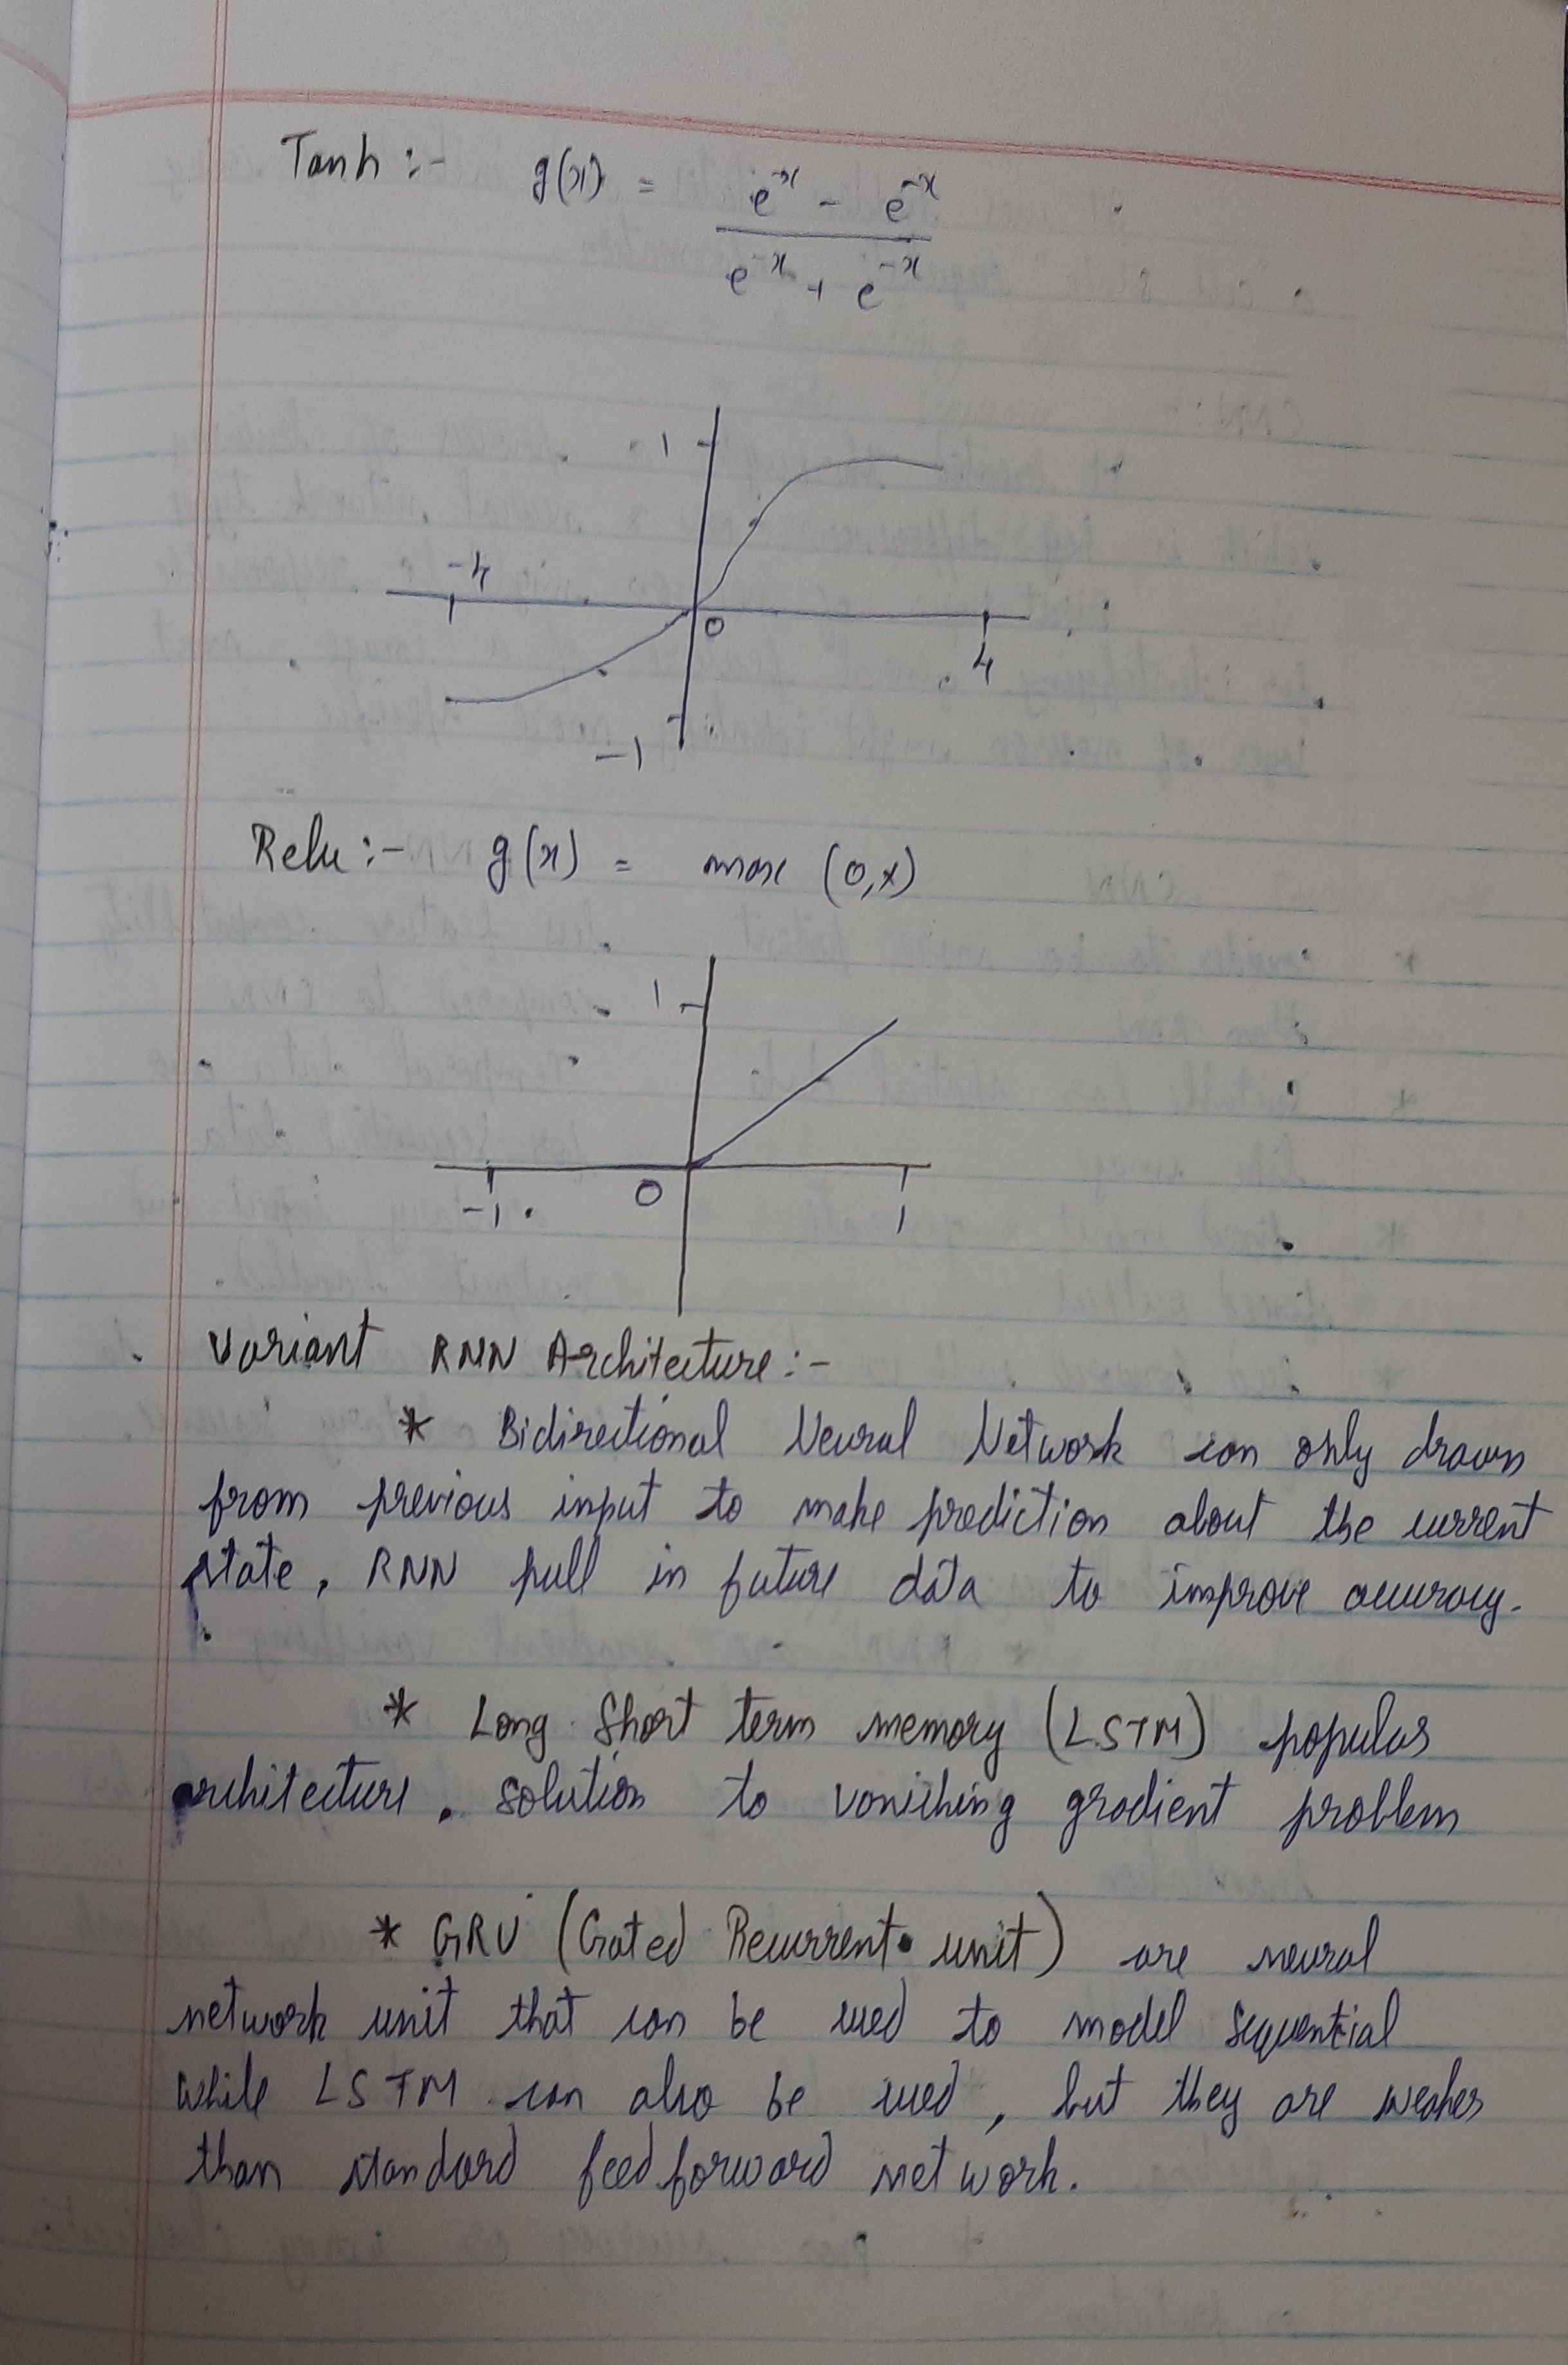

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Load dataset
df = pd.read_csv('/content/ADMISSIONS.csv')
df.drop(['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'diagnosis'], axis=1, inplace=True)
# Remove rows with missing values
df = df.dropna()
df.drop(['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'diagnosis'], axis=1, inplace=True)
# Split dataset into features (X) and target variable (y)
X = df.drop(columns=['has_chartevents_data'])
y = df['has_chartevents_data']

# Preprocess data
df['edregtime'] = pd.to_datetime(df['edregtime'])
df['edouttime'] = pd.to_datetime(df['edouttime'])
df['edregtime_day'] = df['edregtime'].dt.day
df['edregtime_month'] = df['edregtime'].dt.month
df['edregtime_hour'] = df['edregtime'].dt.hour
df['edregtime_minute'] = df['edregtime'].dt.minute
df['edouttime_day'] = df['edouttime'].dt.day
df['edouttime_month'] = df['edouttime'].dt.month
df['edouttime_hour'] = df['edouttime'].dt.hour
df['edouttime_minute'] = df['edouttime'].dt.minute
df.drop(['edregtime', 'edouttime'], axis=1, inplace=True)

# # Encode categorical variables using one-hot encoding
cat_cols = ['ethnicity', 'marital_status', 'insurance' , 'admission_type']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), cat_cols)
    ],
    remainder='passthrough'
)
X_encoded = preprocessor.fit_transform(X)

X_encoded = preprocessor.transform(X)
X_scaled = scaler.fit_transform(X_encoded)
X_scaled = scaler.fit_transform(X)


# Scale features between 0 and 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape data for LSTM and GRU models
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam')

# Build GRU model
model_gru = Sequential()
model_gru.add(GRU(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(Dense(1, activation='sigmoid'))
model_gru.compile(loss='binary_crossentropy', optimizer='adam')

# Fit LSTM model
model_lstm.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Fit GRU model
model_gru.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Make predictions using LSTM and GRU models
y_pred_lstm = model_lstm.predict_classes(X_test)
y_pred_gru = model_gru.predict_classes(X_test)

# Evaluate accuracy of LSTM and GRU models
acc_lstm = accuracy_score(y_test, y_pred_lstm)
acc_gru = accuracy_score(y_test, y_pred_gru)

print(f'LSTM model accuracy: {acc_lstm}')
print(f'GRU model accuracy: {acc_gru}')


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU

# Load the data
data = pd.read_csv('/content/ADMISSIONS.csv')

data.drop(['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'diagnosis'], axis=1, inplace=True)

# Preprocess data
data['edregtime'] = pd.to_datetime(data['edregtime'])
data['edouttime'] = pd.to_datetime(data['edouttime'])
data['edregtime_day'] = data['edregtime'].dt.day
data['edregtime_month'] = data['edregtime'].dt.month
data['edregtime_hour'] = data['edregtime'].dt.hour
data['edregtime_minute'] = data['edregtime'].dt.minute
data['edouttime_day'] = data['edouttime'].dt.day
data['edouttime_month'] = data['edouttime'].dt.month
data['edouttime_hour'] = data['edouttime'].dt.hour
data['edouttime_minute'] = data['edouttime'].dt.minute
data.drop(['edregtime', 'edouttime'], axis=1, inplace=True)

# Preprocess the data
cat_vars = ['admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity']
num_vars = ['edregtime_day', 'edregtime_month', 'edregtime_hour', 'edregtime_minute', 'edouttime_day', 'edouttime_month', 'edouttime_hour', 'edouttime_minute']
target_var = 'hospital_expire_flag'

# Apply label encoding to categorical variables
encoder = LabelEncoder()
for var in cat_vars:
    data[var] = encoder.fit_transform(data[var])

# Scale numerical variables
scaler = StandardScaler()
data[num_vars] = scaler.fit_transform(data[num_vars])

# # Split the data into training and testing sets
# X = data.drop(target_var, axis=1).values
# y = data[target_var].values
# train_size = int(len(X) * 0.8)
# X_train, X_test = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

# # Reshape the input data for LSTM
# X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Split the data into training and testing sets
# Split the data into training and testing sets
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)
X_train = train_data.drop('hospital_expire_flag', axis=1)
X_test = test_data.drop('hospital_expire_flag', axis=1)
y_train = train_data['hospital_expire_flag']
y_test = test_data['hospital_expire_flag']

# Define the model architecture
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(GRU(32, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Reshape the input data to 3D for LSTM
X_train = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
4/4 [==============================] - 8s 543ms/step - loss: nan - accuracy: 0.6019 - val_loss: nan - val_accuracy: 0.6538
Epoch 2/50
4/4 [==============================] - 0s 55ms/step - loss: nan - accuracy: 0.6990 - val_loss: nan - val_accuracy: 0.6538
Epoch 3/50
4/4 [==============================] - 0s 55ms/step - loss: nan - accuracy: 0.6990 - val_loss: nan - val_accuracy: 0.6538
Epoch 4/50
4/4 [==============================] - 0s 53ms/step - loss: nan - accuracy: 0.6990 - val_loss: nan - val_accuracy: 0.6538
Epoch 5/50
4/4 [==============================] - 0s 57ms/step - loss: nan - accuracy: 0.6990 - val_loss: nan - val_accuracy: 0.6538
Epoch 6/50
4/4 [==============================] - 0s 56ms/step - loss: nan - accuracy: 0.6990 - val_loss: nan - val_accuracy: 0.6538
Epoch 7/50
4/4 [==============================] - 0s 55ms/step - loss: nan - accuracy: 0.6990 - val_loss: nan - val_accuracy: 0.6538
Epoch 8/50
4/4 [==============================] - 0s 51ms/step - los

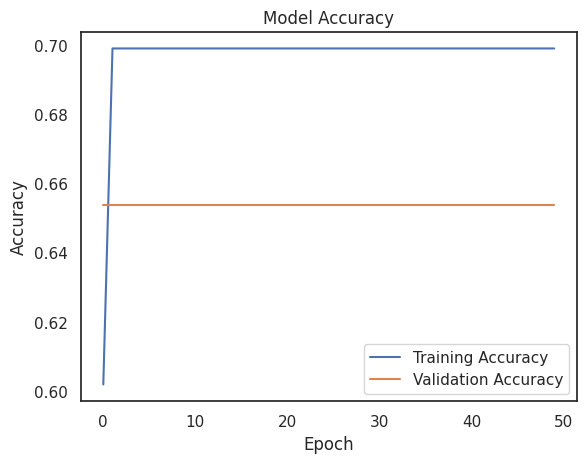

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


If the validation accuracy is consistently lower than the training accuracy, it may be a sign of overfitting. Overfitting occurs when a model is too complex and learns the noise in the training data rather than the underlying patterns. This can cause the model to perform well on the training data but poorly on new, unseen data.